# Compact Convolutional Transformer for MI-EEG Classification

In [1]:

from torchinfo import summary
from model.patch_performer import EEGPatchPerformer
import warnings
warnings.filterwarnings("ignore")

/home/islab-shi/anaconda3/envs/eegcct/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pickle 
import torch 
import time
import numpy as np
import pandas as pd 
import random
import mne
import sys
import matplotlib.pyplot as plt

import torch.nn as nn
from torch import Tensor
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
model = EEGPatchPerformer(num_classes=2,dim=32, heads=4, layers=4, patch=10, ) 

TypeError: __init__() got an unexpected keyword argument 'head'

In [ ]:
summary(model=model,
        input_size=(64, 1, 22, 1000),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
EEGHybridPerformer (EEGHybridPerformer)  [64, 1, 22, 1000]    [64, 2]              6,400                True
├─MultiScaleTemporal (ms)                [64, 1, 22, 1000]    [64, 24, 22, 1000]   --                   True
│    └─ModuleList (branches)             --                   --                   --                   True
│    │    └─Conv2d (0)                   [64, 1, 22, 1000]    [64, 8, 22, 1000]    200                  True
│    │    └─Conv2d (1)                   [64, 1, 22, 1000]    [64, 8, 22, 1000]    408                  True
│    │    └─Conv2d (2)                   [64, 1, 22, 1000]    [64, 8, 22, 1000]    808                  True
├─SpatialDW (spat)                       [64, 24, 22, 1000]   [64, 32, 1, 1000]    --                   True
│    └─Conv2d (dw)                       [64, 24, 22, 1000]   [64, 24, 1, 1000]    528                  True
│    └─Conv2d 

## Data Loading

In [ ]:
datasets = [
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A01.pkl',
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A02.pkl',
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A03.pkl',
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A04.pkl',
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A05.pkl',
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A06.pkl',
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A07.pkl',
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A08.pkl',
    '/workspace-cloud/seiya.narukawa/EEGCCT/pickles/A09.pkl',
]

In [ ]:
def load_data(filename):
    """
    Load data from a file.
    :param filename: Path to the data file.
    :return: Loaded data.
    """
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [ ]:
import glob
# ① ファイルパスリストから被験者ごとの dict をまとめて読み込む
datasets = sorted(glob.glob("pickles/A*.pkl"))
all_subjects = [load_data(fn) for fn in datasets]

# ② subject=0 の辞書を取ってくる
subj0 = all_subjects[0]

# ③ train セッションのデータ
train = subj0["train"]
X_train = train["X"]          # shape=(288,22,1000)
y_train = train["y"]          # label array (0 or 1、artifactマスク等でフィルタ)

# ④ eval セッションのデータ
eval_ = subj0["eval"]
X_eval = eval_["X"]
y_eval = eval_["y"]           # None のはず

# ⑤ メタ情報
meta = subj0["meta"]
print(meta)

{'subject': 'A01', 'sfreq': 250.0, 'ch_names': ['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16'], 'label_map': {'left': 0, 'right': 1, 'feet': 2, 'tongue': 3}, 'window': '0.0–4.0 s (cue-locked)'}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print('Your GPU device name :', torch.cuda.get_device_name()) 

Your GPU device name : NVIDIA GeForce RTX 2080 Ti


## Initialization of Parameters and Model

In [ ]:
def initialize_model(test_sub, val_sub, n_subj=9):
    """
    Initialize parameters, model, and loss functions.
    :param test_sub: Index of the test subject.
    :param val_sub: Index of the validation subject.
    :param n_subj: Total number of subjects.
    :return: Initialized model and parameters.
    """
    parameters = {
        'batch_size': 32,
        'n_epochs': 100,
        'lr': 3e-5,
        'b1': 0.9,
        'b2': 0.999,
        'test_Sub': test_sub,
        'val_Sub': val_sub,
        'n_subjects': n_subj
    }

    model = EEGPatchPerformer(num_classes=2,dim=32, heads=4, layers=4, patch=10) 

    if torch.cuda.is_available():
        model = model.cuda()

    loss_functions = {
        'criterion_l1': nn.L1Loss().cuda(),
        'criterion_l2': nn.MSELoss().cuda(),
        'criterion_cls': nn.CrossEntropyLoss().cuda()
    }

    return model, parameters, loss_functions

## Data Loading and Preprocessing

In [ ]:
def get_source_data(test_sub, val_sub, n_subj=9):
    # １）全被験者ロード
    all_data = [load_data(fn) for fn in datasets]
    
    # ２）テスト／バリデーション辞書
    test_d = all_data[test_sub]['train']
    val_d  = all_data[val_sub] ['train']
    
    # ３）残りでトレイン
    train_idxs = [i for i in range(n_subj) if i not in (test_sub,val_sub)]
    train_ds   = [all_data[i]['train'] for i in train_idxs]
    
    # ４）X,y をそれぞれ取り出して連結
    X_train = np.concatenate([d['X'] for d in train_ds], axis=0)
    y_train = np.concatenate([d['y'] for d in train_ds], axis=0)
    X_val   = val_d ['X']
    y_val   = val_d ['y']
    X_test  = test_d['X']
    y_test  = test_d['y']
    
    # ５）２クラスフィルタリング：left(0), right(1) のみ残す
    mask_tr = np.isin(y_train, [0,1])
    X_train, y_train = X_train[mask_tr], y_train[mask_tr]
    mask_val = np.isin(y_val, [0,1])
    X_val,   y_val   = X_val[mask_val],   y_val[mask_val]
    mask_te  = np.isin(y_test, [0,1])
    X_test,  y_test  = X_test[mask_te],  y_test[mask_te]

    # ６）あとは既存の次元展開／シャッフル／標準化…
    X_train = np.expand_dims(X_train,1)
    X_val   = np.expand_dims(X_val,  1)
    X_test  = np.expand_dims(X_test, 1)

    # shuffle train
    idx = np.random.permutation(len(X_train))
    X_train, y_train = X_train[idx], y_train[idx]

    # standardize based on train set
    μ, σ = X_train.mean(), X_train.std()
    X_train = (X_train - μ) / σ
    X_val   = (X_val   - μ) / σ
    X_test  = (X_test  - μ) / σ

    return X_train, y_train, X_val, y_val, X_test, y_test


In [ ]:
def prepare_dataloaders(X_train, y_train, X_val, y_val, batch_size):
    """
    Convert numpy arrays to PyTorch tensors and prepare DataLoaders for training and validation.
    :param X_train: Training data (numpy array).
    :param y_train: Training labels (numpy array).
    :param X_val: Validation data (numpy array).
    :param y_val: Validation labels (numpy array).
    :param batch_size: Batch size for the DataLoader.
    :return: DataLoaders for training and validation.
    """
    # Convert numpy arrays to Tensors
    train_data = torch.from_numpy(X_train).type(torch.cuda.FloatTensor)
    train_labels = torch.from_numpy(y_train).type(torch.cuda.LongTensor)
    val_data = torch.from_numpy(X_val).type(torch.cuda.FloatTensor)
    val_labels = torch.from_numpy(y_val).type(torch.cuda.LongTensor)

    # Prepare DataLoader for training data
    train_dataset = TensorDataset(train_data, train_labels)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # Prepare DataLoader for validation data
    val_dataset = TensorDataset(val_data, val_labels)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [ ]:
def augment_data(X, y, batch_size, n_segments=3):
    # X: (n_trials,1,22,1000)
    n_trials,_,n_ch,n_t = X.shape
    half = batch_size // 2

    # 1000 samples を n_segments 等分する境界を計算
    bounds = [ int(round(i * n_t / n_segments)) for i in range(n_segments+1) ]
    # e.g. bounds = [0, 333, 667, 1000]

    aug_data  = np.zeros((half,1,n_ch,n_t), dtype=X.dtype)
    aug_label = np.zeros(half,      dtype=y.dtype)

    classes = [0,1]  # 左手/右手 のラベル

    for i in range(half):
        lbl = np.random.choice(classes)
        aug_label[i] = lbl

        # 各セグメントごとに同クラスからランダムに試行を選ぶ
        idxs = np.where(y == lbl)[0]
        picks = np.random.choice(idxs, size=n_segments, replace=True)

        segments = []
        for s in range(n_segments):
            st, ed = bounds[s], bounds[s+1]
            segments.append(X[picks[s], 0, :, st:ed])

        # 再度連結して長さ 1000 に戻す
        new_trial = np.concatenate(segments, axis=-1)  # (22,1000)
        aug_data[i,0] = new_trial

    # Tensor 化して GPU へ
    tdata   = torch.from_numpy(aug_data).float().cuda()
    tlabels = torch.from_numpy(aug_label).long().cuda()
    return tdata, tlabels

## Model Training

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        """
        Initialize the EarlyStopping object.
        :param patience: Number of epochs to wait after min has been hit. After this number, training stops.
        :param min_delta: Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            #print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [ ]:
def train_model(model, optimizer, loss_functions, train_loader, val_loader, parameters, X_train, y_train, early_stopping):
    """
    Train the model.
    :param model: The neural network model to train.
    :param optimizer: Optimizer for the model.
    :param criterion_cls: Loss function for classification.
    :param train_loader: DataLoader for training data.
    :param val_loader: DataLoader for validation data.
    :param n_epochs: Number of epochs to train the model.
    :return: Trained model.
    """
    # Lists to keep track of metrics
    train_losses, val_losses, val_accuracies = [], [], []
    
    # Training loop
    for epoch in range(parameters['n_epochs']):
        model.train()
        train_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            images = images.cuda()
            labels = labels.cuda()
            
            # Data augmentation
            aug_images, aug_labels = augment_data(X_train, y_train, parameters['batch_size'])
            images = torch.cat((images, aug_images))
            labels = torch.cat((labels, aug_labels))

            # Forward pass
            outputs = model(images)
            loss = loss_functions['criterion_cls'](outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        # Validation accuracy
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.cuda()
                labels = labels.cuda()
                outputs = model(images)
                loss = loss_functions['criterion_cls'](outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            # Calculate average losses and accuracy
            train_loss = train_loss / len(train_loader)
            val_loss = val_loss / len(val_loader)
            val_accuracy = 100 * correct / total
            print(f'Epoch [{epoch+1}/{parameters["n_epochs"]}], Train Loss: {loss.item():.4f}, Val Acc: {val_accuracy:.2f}%')
            
        # Append metrics to lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Check early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return model, train_losses, val_losses, val_accuracies

## Model Evaluation

In [ ]:
def test_model(model, loss_functions, test_loader):
    """
    Test the model using the test dataset.
    :param model: The trained neural network model.
    :param criterion_cls: Loss function for classification.
    :param test_loader: DataLoader for test data.
    :return: Test accuracy and test loss.
    """
    # Evaluate the model
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images)
            loss = loss_functions['criterion_cls'](outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    
    return test_accuracy, test_loss

seed is 458
Val Subject 2:
Epoch [1/100], Train Loss: 0.7097, Val Acc: 49.31%
Epoch [2/100], Train Loss: 0.7069, Val Acc: 47.22%
Epoch [3/100], Train Loss: 0.7050, Val Acc: 43.06%
Epoch [4/100], Train Loss: 0.7048, Val Acc: 44.44%
Epoch [5/100], Train Loss: 0.7040, Val Acc: 49.31%
Epoch [6/100], Train Loss: 0.7032, Val Acc: 47.22%
Epoch [7/100], Train Loss: 0.7030, Val Acc: 47.92%
Epoch [8/100], Train Loss: 0.7023, Val Acc: 49.31%
Epoch [9/100], Train Loss: 0.7017, Val Acc: 43.06%
Epoch [10/100], Train Loss: 0.7012, Val Acc: 43.06%
Epoch [11/100], Train Loss: 0.7007, Val Acc: 44.44%
Early stopping


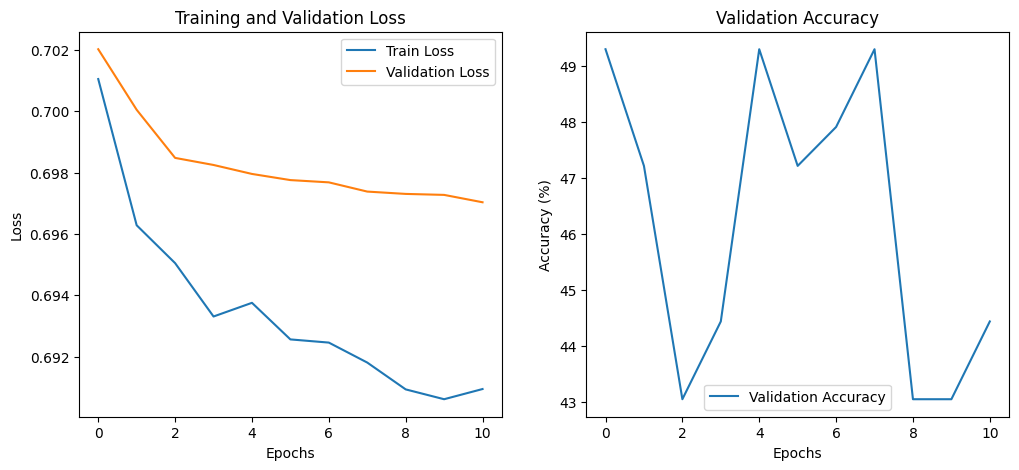

Test Loss: 0.6918, Test Accuracy: 51.39%
Test Subject 1: Test Acc = 51.39%, Test Loss = 0.6918
Training complete in 0m 5s

seed is 1118
Val Subject 3:
Epoch [1/100], Train Loss: 0.7141, Val Acc: 45.83%
Epoch [2/100], Train Loss: 0.7137, Val Acc: 49.31%
Epoch [3/100], Train Loss: 0.7125, Val Acc: 47.92%
Epoch [4/100], Train Loss: 0.7125, Val Acc: 50.00%
Epoch [5/100], Train Loss: 0.7121, Val Acc: 50.00%
Epoch [6/100], Train Loss: 0.7116, Val Acc: 44.44%
Epoch [7/100], Train Loss: 0.7108, Val Acc: 44.44%
Epoch [8/100], Train Loss: 0.7111, Val Acc: 46.53%
Epoch [9/100], Train Loss: 0.7110, Val Acc: 45.83%
Epoch [10/100], Train Loss: 0.7111, Val Acc: 45.83%
Epoch [11/100], Train Loss: 0.7112, Val Acc: 45.83%
Early stopping


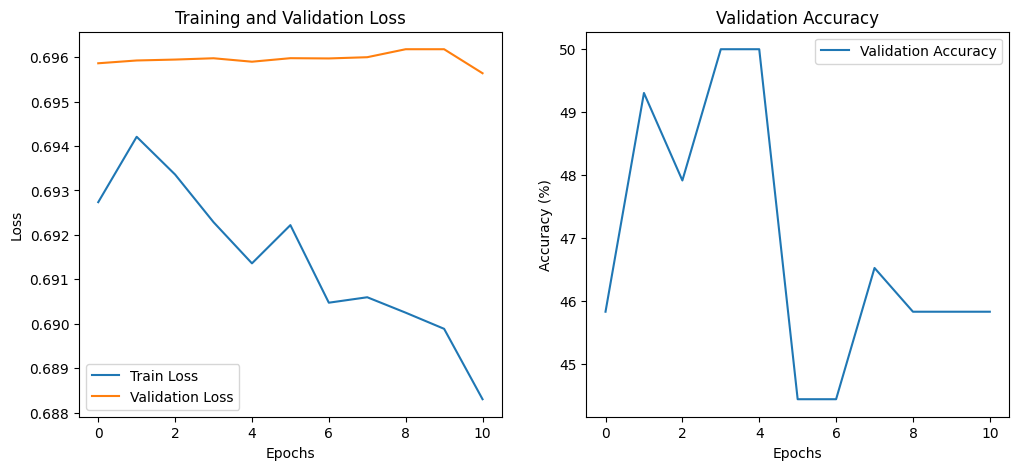

Test Loss: 0.6950, Test Accuracy: 47.22%
Test Subject 2: Test Acc = 47.22%, Test Loss = 0.6950
Training complete in 0m 5s

seed is 1940
Val Subject 4:
Epoch [1/100], Train Loss: 0.6922, Val Acc: 50.00%
Epoch [2/100], Train Loss: 0.6900, Val Acc: 49.31%
Epoch [3/100], Train Loss: 0.6895, Val Acc: 51.39%
Epoch [4/100], Train Loss: 0.6897, Val Acc: 45.83%
Epoch [5/100], Train Loss: 0.6901, Val Acc: 46.53%
Epoch [6/100], Train Loss: 0.6907, Val Acc: 50.69%
Epoch [7/100], Train Loss: 0.6911, Val Acc: 52.08%
Epoch [8/100], Train Loss: 0.6915, Val Acc: 47.22%
Epoch [9/100], Train Loss: 0.6918, Val Acc: 49.31%
Epoch [10/100], Train Loss: 0.6923, Val Acc: 47.22%
Epoch [11/100], Train Loss: 0.6928, Val Acc: 50.69%
Early stopping


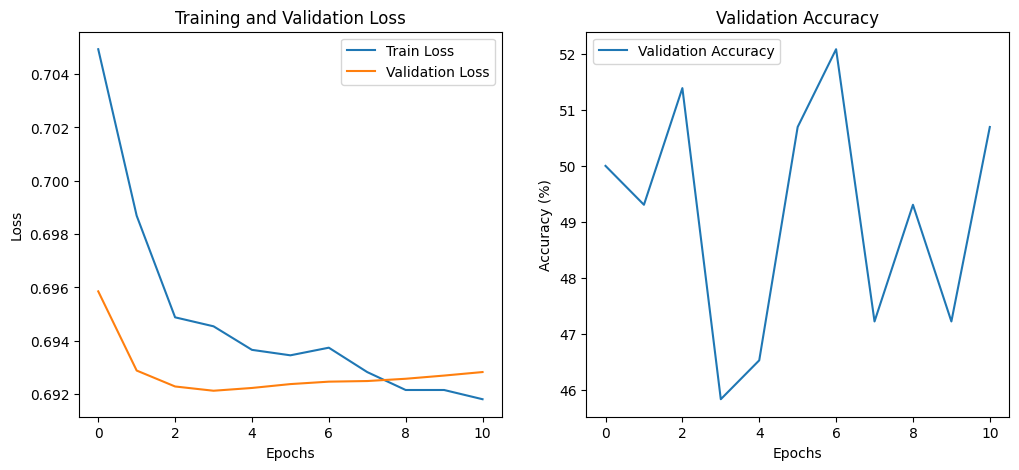

Test Loss: 0.6960, Test Accuracy: 47.92%
Test Subject 3: Test Acc = 47.92%, Test Loss = 0.6960
Training complete in 0m 5s

seed is 149
Val Subject 5:
Epoch [1/100], Train Loss: 0.7068, Val Acc: 58.33%
Epoch [2/100], Train Loss: 0.7052, Val Acc: 57.64%
Epoch [3/100], Train Loss: 0.7057, Val Acc: 56.94%
Epoch [4/100], Train Loss: 0.7057, Val Acc: 56.94%
Epoch [5/100], Train Loss: 0.7067, Val Acc: 58.33%
Epoch [6/100], Train Loss: 0.7072, Val Acc: 54.86%
Epoch [7/100], Train Loss: 0.7076, Val Acc: 56.25%
Epoch [8/100], Train Loss: 0.7079, Val Acc: 58.33%
Epoch [9/100], Train Loss: 0.7083, Val Acc: 58.33%
Epoch [10/100], Train Loss: 0.7090, Val Acc: 58.33%
Epoch [11/100], Train Loss: 0.7095, Val Acc: 61.81%
Early stopping


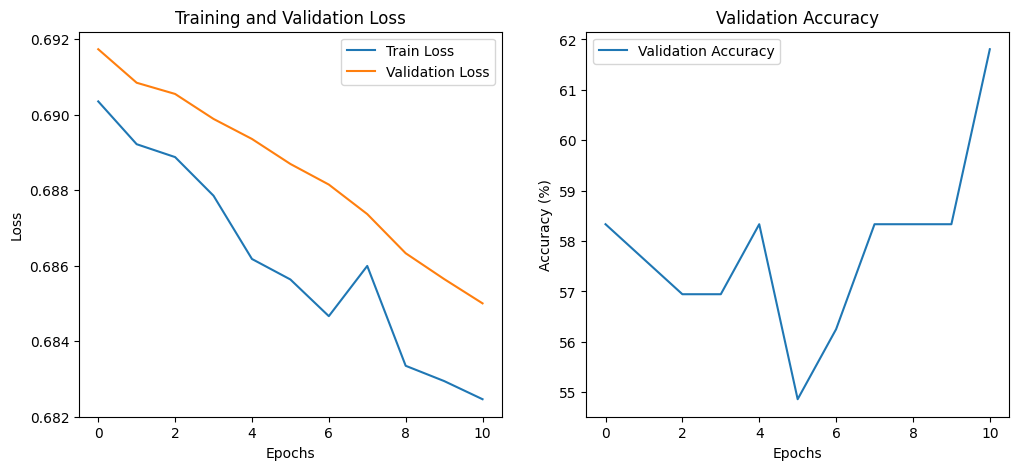

Test Loss: 0.6988, Test Accuracy: 47.92%
Test Subject 4: Test Acc = 47.92%, Test Loss = 0.6988
Training complete in 0m 5s

seed is 1635
Val Subject 6:
Epoch [1/100], Train Loss: 0.6847, Val Acc: 45.83%
Epoch [2/100], Train Loss: 0.6846, Val Acc: 49.31%
Epoch [3/100], Train Loss: 0.6848, Val Acc: 48.61%
Epoch [4/100], Train Loss: 0.6855, Val Acc: 50.69%
Epoch [5/100], Train Loss: 0.6857, Val Acc: 51.39%
Epoch [6/100], Train Loss: 0.6865, Val Acc: 51.39%
Epoch [7/100], Train Loss: 0.6872, Val Acc: 51.39%
Epoch [8/100], Train Loss: 0.6870, Val Acc: 50.69%
Epoch [9/100], Train Loss: 0.6868, Val Acc: 51.39%
Epoch [10/100], Train Loss: 0.6872, Val Acc: 50.69%
Epoch [11/100], Train Loss: 0.6879, Val Acc: 54.17%
Early stopping


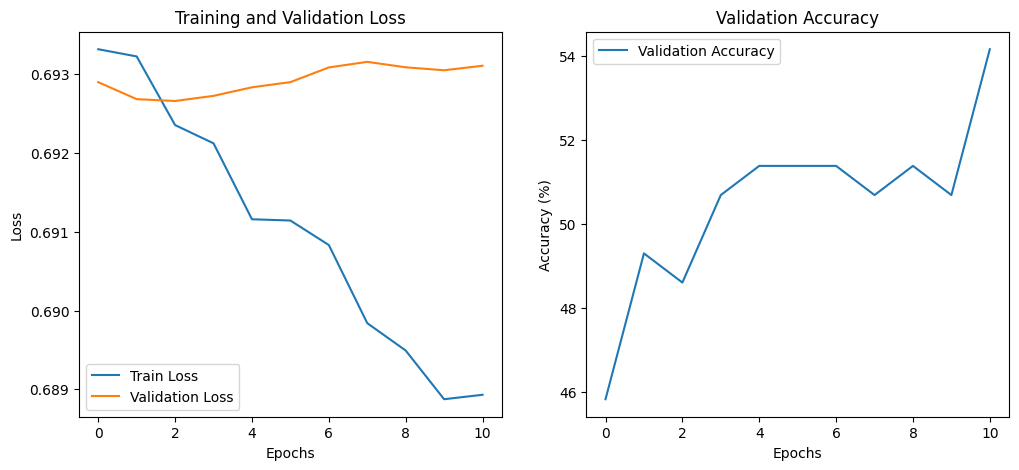

Test Loss: 0.6898, Test Accuracy: 56.25%
Test Subject 5: Test Acc = 56.25%, Test Loss = 0.6898
Training complete in 0m 5s

seed is 212
Val Subject 7:
Epoch [1/100], Train Loss: 0.6734, Val Acc: 61.11%
Epoch [2/100], Train Loss: 0.6707, Val Acc: 64.58%
Epoch [3/100], Train Loss: 0.6688, Val Acc: 68.06%
Epoch [4/100], Train Loss: 0.6678, Val Acc: 68.75%
Epoch [5/100], Train Loss: 0.6671, Val Acc: 70.83%
Epoch [6/100], Train Loss: 0.6663, Val Acc: 70.83%
Epoch [7/100], Train Loss: 0.6654, Val Acc: 66.67%
Epoch [8/100], Train Loss: 0.6647, Val Acc: 67.36%
Epoch [9/100], Train Loss: 0.6639, Val Acc: 69.44%
Epoch [10/100], Train Loss: 0.6629, Val Acc: 69.44%
Epoch [11/100], Train Loss: 0.6615, Val Acc: 68.75%
Early stopping


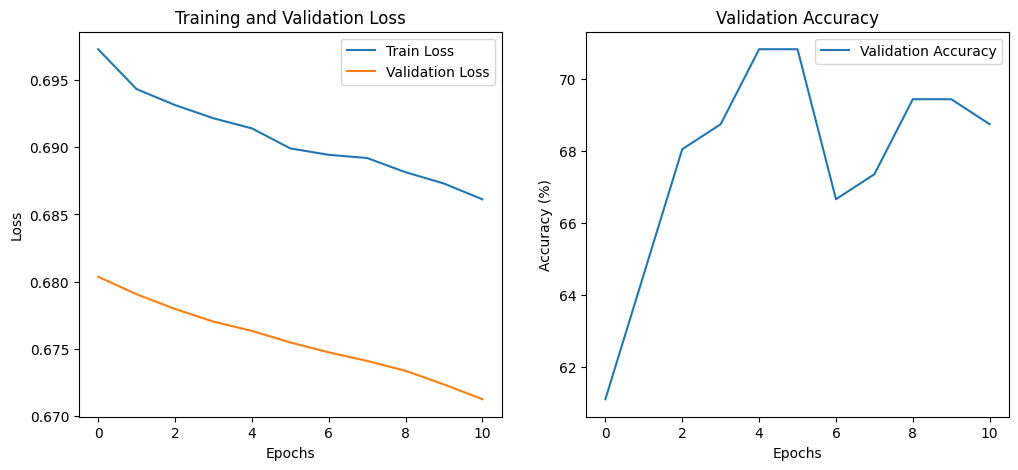

Test Loss: 0.6885, Test Accuracy: 54.86%
Test Subject 6: Test Acc = 54.86%, Test Loss = 0.6885
Training complete in 0m 5s

seed is 355
Val Subject 8:
Epoch [1/100], Train Loss: 0.6917, Val Acc: 50.69%
Epoch [2/100], Train Loss: 0.6907, Val Acc: 50.00%
Epoch [3/100], Train Loss: 0.6908, Val Acc: 50.00%
Epoch [4/100], Train Loss: 0.6905, Val Acc: 50.00%
Epoch [5/100], Train Loss: 0.6900, Val Acc: 50.69%
Epoch [6/100], Train Loss: 0.6899, Val Acc: 51.39%
Epoch [7/100], Train Loss: 0.6897, Val Acc: 47.22%
Epoch [8/100], Train Loss: 0.6900, Val Acc: 50.69%
Epoch [9/100], Train Loss: 0.6896, Val Acc: 50.00%
Epoch [10/100], Train Loss: 0.6891, Val Acc: 52.08%
Epoch [11/100], Train Loss: 0.6896, Val Acc: 52.08%
Early stopping


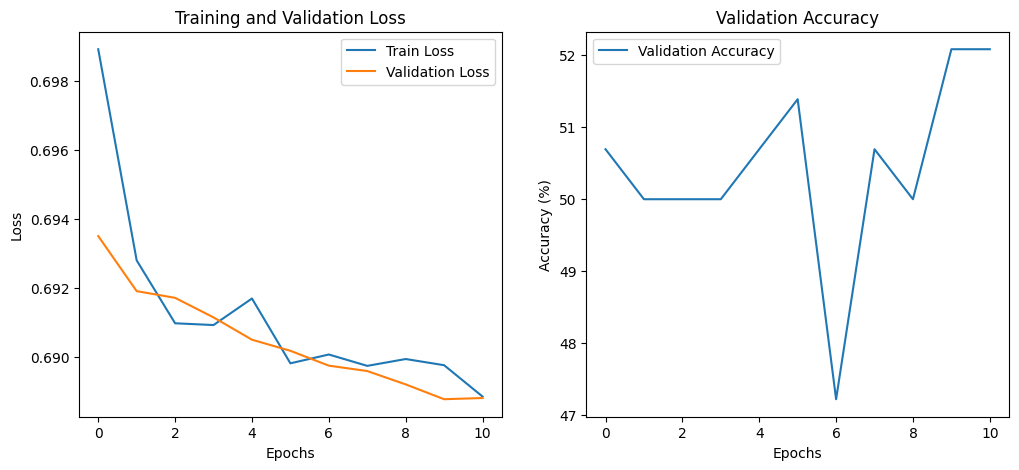

Test Loss: 0.6907, Test Accuracy: 53.47%
Test Subject 7: Test Acc = 53.47%, Test Loss = 0.6907
Training complete in 0m 5s

seed is 300
Val Subject 9:
Epoch [1/100], Train Loss: 0.6953, Val Acc: 50.00%
Epoch [2/100], Train Loss: 0.6917, Val Acc: 50.69%
Epoch [3/100], Train Loss: 0.6909, Val Acc: 52.78%
Epoch [4/100], Train Loss: 0.6905, Val Acc: 52.78%
Epoch [5/100], Train Loss: 0.6903, Val Acc: 50.69%
Epoch [6/100], Train Loss: 0.6900, Val Acc: 52.08%
Epoch [7/100], Train Loss: 0.6893, Val Acc: 51.39%
Epoch [8/100], Train Loss: 0.6890, Val Acc: 51.39%
Epoch [9/100], Train Loss: 0.6885, Val Acc: 53.47%
Epoch [10/100], Train Loss: 0.6882, Val Acc: 52.08%
Epoch [11/100], Train Loss: 0.6877, Val Acc: 47.92%
Early stopping


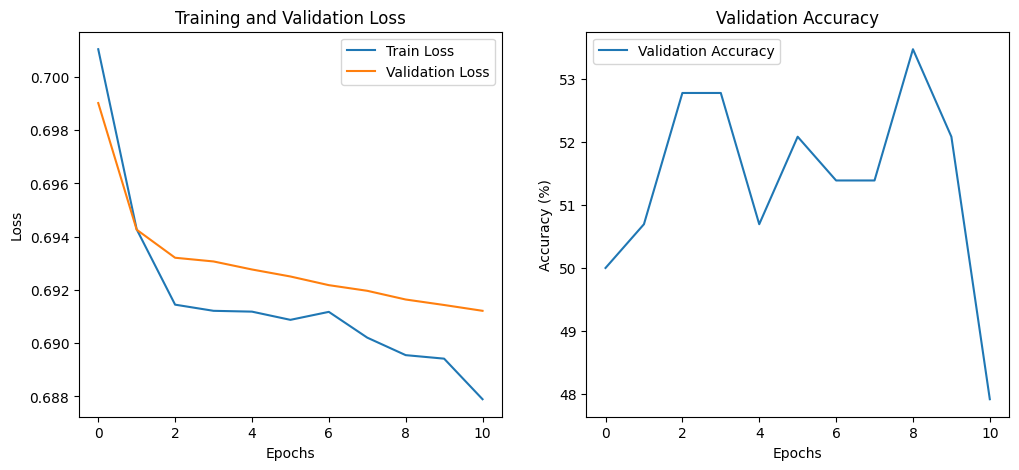

Test Loss: 0.6920, Test Accuracy: 49.31%
Test Subject 8: Test Acc = 49.31%, Test Loss = 0.6920
Training complete in 0m 5s

seed is 472
Val Subject 1:
Epoch [1/100], Train Loss: 0.6675, Val Acc: 50.00%
Epoch [2/100], Train Loss: 0.6709, Val Acc: 50.00%
Epoch [3/100], Train Loss: 0.6781, Val Acc: 50.00%
Epoch [4/100], Train Loss: 0.6843, Val Acc: 49.31%
Epoch [5/100], Train Loss: 0.6893, Val Acc: 46.53%
Epoch [6/100], Train Loss: 0.6927, Val Acc: 47.22%
Epoch [7/100], Train Loss: 0.6944, Val Acc: 50.00%
Epoch [8/100], Train Loss: 0.6952, Val Acc: 47.22%
Epoch [9/100], Train Loss: 0.6963, Val Acc: 46.53%
Epoch [10/100], Train Loss: 0.6982, Val Acc: 45.83%
Epoch [11/100], Train Loss: 0.6947, Val Acc: 48.61%
Epoch [12/100], Train Loss: 0.6983, Val Acc: 45.14%
Epoch [13/100], Train Loss: 0.6958, Val Acc: 49.31%
Epoch [14/100], Train Loss: 0.6973, Val Acc: 46.53%
Early stopping


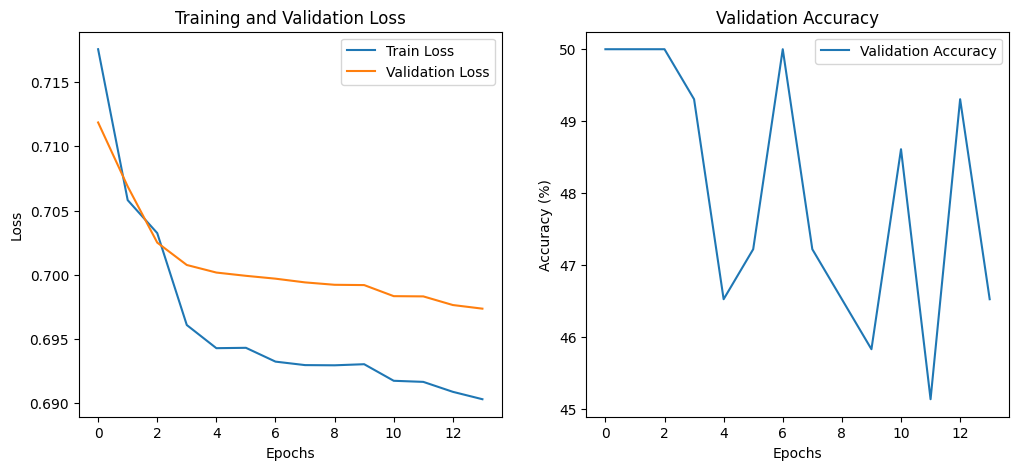

Test Loss: 0.6926, Test Accuracy: 52.78%
Test Subject 9: Test Acc = 52.78%, Test Loss = 0.6926
Training complete in 0m 6s

Average Test Accuracy: 51.23%
Average Test Loss: 0.6928
   Test Subject  Val Subject   Test Acc  Seed
0             1            2  51.388889   458
1             2            3  47.222222  1118
2             3            4  47.916667  1940
3             4            5  47.916667   149
4             5            6  56.250000  1635
5             6            7  54.861111   212
6             7            8  53.472222   355
7             8            9  49.305556   300
8             9            1  52.777778   472


In [ ]:
# Assuming you have n subjects in your dataset
n_subjects = 9

# Results storage
all_test_accuracies = []
all_test_losses = []

# Initialize an empty DataFrame
results_df = pd.DataFrame(columns=['Test Subject', 'Val Subject', 'Test Acc', 'Seed'])

for test_sub in range(n_subjects):
    start_time = time.time()
    
    seed_n = np.random.randint(2021)
    print('seed is ' + str(seed_n))
    random.seed(seed_n)
    np.random.seed(seed_n)
    torch.manual_seed(seed_n)
    torch.cuda.manual_seed(seed_n)
    torch.cuda.manual_seed_all(seed_n)
    
    # Selecting the validation subject (can be the same or different from the test subject)
    val_sub = (test_sub + 1) % n_subjects
    print(f"Val Subject {val_sub + 1}:")

    # Initialize model and get source data for this iteration
    model, parameters, loss_functions = initialize_model(test_sub, val_sub, n_subjects)
    X_train, y_train, X_val, y_val, X_test, y_test = get_source_data(test_sub, val_sub, n_subjects)
    train_loader, val_loader = prepare_dataloaders(X_train, y_train, X_val, y_val, parameters['batch_size'])
    test_loader = prepare_dataloaders(X_test, y_test, X_test, y_test, parameters['batch_size'])[1]  # Only need test loader

    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['lr'], betas=(parameters['b1'], parameters['b2']))

    # Train the model
    early_stopping = EarlyStopping(patience=10, min_delta=0.01)
    trained_model, train_losses, val_losses, val_accuracies = train_model(model, optimizer, loss_functions, train_loader, val_loader, parameters, X_train, y_train, early_stopping)
    
    # Number of epochs trained is either the total number of epochs or until early stopping
    epochs_trained = parameters['n_epochs'] if not early_stopping.early_stop else early_stopping.counter
    
    # Plotting
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()
    
    # Test the model
    test_accuracy, test_loss = test_model(trained_model, loss_functions, test_loader)

    # Store results
    all_test_accuracies.append(test_accuracy)
    all_test_losses.append(test_loss)

    print(f"Test Subject {test_sub + 1}: Test Acc = {test_accuracy:.2f}%, Test Loss = {test_loss:.4f}")
    
    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('\n======================================')
    
    # Add the results to the DataFrame
    results_df.loc[len(results_df)] = {
        'Test Subject': test_sub + 1,
        'Val Subject' : val_sub + 1,
        'Test Acc'    : test_accuracy,
        'Seed'        : seed_n
}

# Calculate average performance across all LOSO rounds
average_accuracy = np.mean(all_test_accuracies)
average_loss = np.mean(all_test_losses)

print(f"Average Test Accuracy: {average_accuracy:.2f}%")
print(f"Average Test Loss: {average_loss:.4f}")

# Display the results DataFrame
print(results_df)

## Utility Functions

In [ ]:
def save_model(model, path):
    """
    Save the trained model to a file.
    :param model: The trained model.
    :param path: File path to save the model.
    """
    torch.save(model.state_dict(), path)

def load_model(path):
    """
    Load a model from a file.
    :param path: File path to the model.
    :return: Loaded model.
    """
    # Instantiate the model
    model = model_class(*args, **kwargs)
    
    # Load the model state dict
    model.load_state_dict(torch.load(path))
    
    return model


In [ ]:
save_model(trained_model, 'results_2024_conf/model_cct.pth')

FileNotFoundError: [Errno 2] No such file or directory: 'results_2024_conf/model_cct.pth'

In [ ]:
my_loaded_model = load_model('results_2024_conf/model_cct.pth', ['left_hand', 'right_hand'])